Boilerplate, load up libraries

In [1]:
#!/usr/bin/env python

# Generative Adversarial Networks (GAN) example in PyTorch. Tested with PyTorch 0.4.1, Python 3.6.7 (Nov 2018)
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
# Code: https://github.com/devnag/pytorch-generative-adversarial-networks
#Updated to PyTorch stable 1.0 by Brandon Foltz in February 2019

%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

matplotlib_is_available = True
try:
  from matplotlib import pyplot as plt
except ImportError:
  print("Will skip plotting; matplotlib is not available.")
  matplotlib_is_available = False

# Data params
data_mean = 4
data_stddev = 1.25

# ### Uncomment only one of these to define what data is actually sent to the Discriminator
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)

print("Using data [%s]" % (name))

Using data [Only 4 moments]


**1.)** R: In our case, we’ll start with the simplest possible R — a bell curve. This function takes a mean and a standard deviation and returns a function which provides the right shape of sample data from a Gaussian with those parameters. In our sample code, we’ll use a mean of 4.0 and a standard deviation of 1.25.

**2.)** I: The input into the generator is also random, but to make our job a little bit harder, let’s use a uniform distribution rather than a normal one. This means that our model G can’t simply shift/scale the input to copy R, but has to reshape the data in a non-linear way.

In [2]:
###### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian


**3.)** G: The generator is a standard feedforward graph — two hidden layers, three linear maps. We’re using a hyperbolic tangent activation function ‘cuz we’re old-school like that. G is going to get the uniformly distributed data samples from I and somehow mimic the normally distributed samples from R — without ever seeing R.

**4.)** D: The discriminator code is very similar to G’s generator code; a feedforward graph with two hidden layers and three linear maps. The activation function here is a sigmoid — nothing fancy, people. It’s going to get samples from either R or G and will output a single scalar between 0 and 1, interpreted as ‘fake’ vs. ‘real’. In other words, this is about as milquetoast as a neural net can get.

In [3]:
# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        #self.map2 = nn.Linear(hidden_size, hidden_size) #default
        self.gru = nn.GRU(input_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        #x = self.map2(x)
        #x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

**5.)** Finally, the training loop alternates between two modes: first training D on real data vs. fake data, with accurate labels (think of this as Police Academy); and then training G to fool D, with inaccurate labels (this is more like those preparation montages from Ocean’s Eleven). It’s a fight between good and evil, people.



Epoch 0: 
D (0.644446074962616 real_err, 0.7400192618370056 fake_err)
G (0.6489118933677673 err); 
Real Dist ([4.007727809348703, 1.2521892064984312])
Fake Dist ([-0.4761937615156174, 0.023463772663983067]) 
Epoch 1000: 
D (0.671393871307373 real_err, 0.6686647534370422 fake_err)
G (0.7112776041030884 err); 
Real Dist ([4.003421528238058, 1.2617335206101121])
Fake Dist ([4.306916990184784, 0.058727684668283646]) 
Epoch 2000: 
D (0.47875091433525085 real_err, 0.45765817165374756 fake_err)
G (1.0012856721878052 err); 
Real Dist ([3.9940797298925927, 1.2392037943428542])
Fake Dist ([6.313256820774078, 0.13149769733606056]) 
Epoch 3000: 
D (0.19794254004955292 real_err, 0.1988365650177002 fake_err)
G (1.8006993532180786 err); 
Real Dist ([4.007732957550883, 1.2497972606670205])
Fake Dist ([3.467608592748642, 0.3941003565467085]) 
Epoch 4000: 
D (0.5886792540550232 real_err, 0.6513221859931946 fake_err)
G (0.7227017879486084 err); 
Real Dist ([3.97819097815603, 1.2756859221938257])
Fake Dis

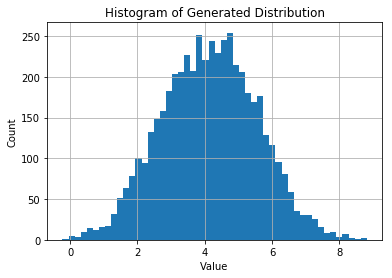

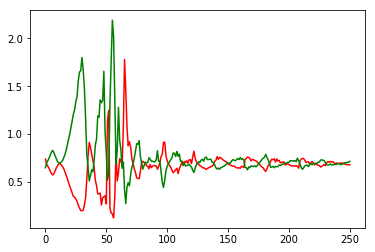

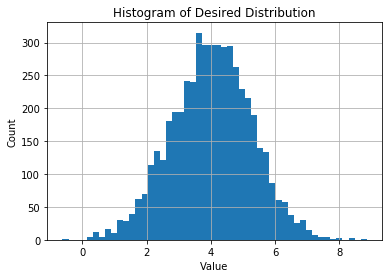

In [16]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)
    
def hist_of_target_distribution(sampler, count):
    values = sampler(count)
    if matplotlib_is_available:
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Desired Distribution')
        plt.grid(True)
        plt.show()

def train():
    # Model parameters
    g_input_size = 5      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 20    # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 5000   # Minibatch size - cardinality of distributions
    d_hidden_size = 50    # Discriminator complexity (original)
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 25000 #original 5000
    print_interval = 1000
    loss_log_interval = 100
    df_losses = []
    g_losses = []
    
    #original params
    #d_steps = 20
    #g_steps = 20
    
    d_steps = 1
    g_steps = 1
    
    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    #Original settings:
    #discriminator_activation_function = torch.sigmoid
    #generator_activation_function = torch.tanh

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.sigmoid
    
    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = d_sampler(d_input_size)
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, torch.tensor([1.0])) # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = gi_sampler(minibatch_size, g_input_size)
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, torch.tensor([0.0])) # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = gi_sampler(minibatch_size, g_input_size)
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, torch.tensor([1.0])) # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0 or epoch == num_epochs-1:
            print("Epoch %s: \nD (%s real_err, %s fake_err)\nG (%s err); \nReal Dist (%s)\nFake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))

        if epoch % loss_log_interval == 0 or epoch == num_epochs-1:
            df_losses.append(dfe)
            g_losses.append(ge)
            
    if matplotlib_is_available:
        values = extract(g_fake_data)
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)
        plt.show()
        
        #plot the losses against each other
        plt.plot(range(len(df_losses)), df_losses, 'r-', range(len(g_losses)), g_losses, 'g-')
        plt.show()


train()
hist_of_target_distribution(get_distribution_sampler(data_mean, data_stddev), 5000)


In [ ]:
plt.plot([1,2,3], [7,6,7], 'g-')
